In [1]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import langgraph.prebuilt as prebuilt
print(dir(prebuilt))

['InjectedState', 'InjectedStore', 'ToolNode', 'ToolRuntime', 'ValidationNode', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'chat_agent_executor', 'create_react_agent', 'tool_node', 'tool_validator', 'tools_condition']


In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [5]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [17]:
## Define simple state
class AgentState(MessagesState):
    pass  # Just use MessagesState, no extra fields needed

In [18]:
## Simple tool for web search
@tool
def search_web(query: str) -> str:
    """Search the web for relevant information."""
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

In [8]:
from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001A453E6FB80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A453E6F070>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [19]:
## Researcher agent - gathers information
def researcher_agent(state: AgentState):
    """Research agent that gathers information"""
    messages = state["messages"]
    
    system_msg = SystemMessage(content="""You are a research assistant. 
    Based on the user's request, provide comprehensive research including:
    - Key facts and background information
    - Current trends and developments
    - Important statistics or data
    - Real-world examples
    
    Be detailed and informative.""")
    
    # Get research from LLM
    response = llm.invoke([system_msg] + messages)
    
    return {"messages": [response]}

In [25]:
## Writer agent - creates final summary
def writer_agent(state: AgentState):
    """Writer agent that creates a polished summary"""
    messages = state["messages"]
    
    # Get the researcher's findings
    researcher_content = messages[-1].content if len(messages) > 1 else ""
    
    system_msg = SystemMessage(content=f"""You are a professional writer. 
    Based on the research findings below, create a clear, well-structured summary report.
    
    Research Findings:
    {researcher_content}
    
    Create a comprehensive report with:
    - Executive Summary
    - Key Findings  
    - Important Insights
    - Use Cases and Examples
    - Conclusion
    
    Make it professional, detailed, and easy to understand.""")
    
    # Get final report from LLM
    response = llm.invoke([system_msg, messages[0]])  # Include original request
    
    return {"messages": [response]}

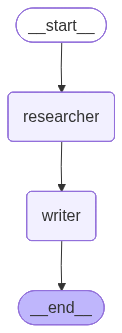

In [21]:
## Build simple graph: start -> researcher -> writer -> end

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define simple linear flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)

# Compile
final_workflow = workflow.compile()

final_workflow

In [26]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})


In [27]:
# Show final result
print(response["messages"][-1].content)

 However, it is essential to address concerns around job displacement and ensure that AI is used responsibly and transparently.

**Recommendations**

1. **Invest in AI Research and Development**: Businesses should invest in AI research and development to stay ahead of the curve and leverage the latest agentic AI technologies.
2. **Develop Explainable AI Capabilities**: Companies should prioritize Explainable AI capabilities to ensure transparency and trust in AI decision-making.
3. **Upskill and Reskill Workforce**: Businesses should invest in upskilling and reskilling their workforce to prepare for the impact of automation on jobs.
4. **Address Social and Ethical Concerns**: Companies should address social and ethical concerns surrounding AI, including job displacement, bias, and accountability.
